In [32]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns 

from sklearn.metrics import silhouette_score, silhouette_samples
import sklearn.metrics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering

import itertools

import scipy

#import sys
#!{sys.executable} -m pip install pandas-profiling
from pandas_profiling import ProfileReport
#from yellowbrick.cluster import SilhouetteVisualizer, InterclusterDistance, KElbowVisualizer

#from kmodes.kmodes import KModes

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# This will ensure that matplotlib figures don't get cut off when saving with savefig()
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

# Reading Data and Viewing Data

In [33]:
data = pd.read_csv("Casino Data.csv")
data.head(5)

,ID,Site,Mail_Consent,Email_Consent,Tier,City,Country,Age,Age_Group,Gender,...,One_Month_Trips,Number_of_Comps_Taken_12_Months,Value_of_Comps_Taken_12_Months,Twelve_Month_Net_Comp,Number_of_Comps_Taken_3_Months,Value_of_Comps_Taken_3_Months,Three_Month_Net_Comp,Number_of_Comps_Taken_1_Month,Value_of_Comps_Taken_1_Month,One_Month_Net_Comp
0,700012,WB,Y,N,GOLD,MISSISSAUGA,Canada,54,51-58,FEMALE,...,0,19,559,-28.704805,0,0,25.788403,0,0,0.000000
1,700014,WB,Y,N,GOLD,WOODBRIDGE,Canada,76,75+,MALE,...,0,0,0,48.307880,0,0,0.000000,0,0,0.000000
2,700016,WB,N,N,GOLD,TORONTO,Canada,57,51-58,MALE,...,0,9,189,100.957670,1,44,8.175142,0,0,0.000000
3,700020,WB,Y,N,GOLD,ASHBURN,Canada,58,51-58,MALE,...,5,28,872,867.935912,4,138,292.803776,3,108,98.934136
4,700024,WB,N,N,GOLD,MISSISSAUGA,Canada,48,43-50,FEMALE,...,3,37,1198,1118.172606,10,364,398.924222,4,184,17.198789


# CLEANING DATA

## Part 1 - Replacing/Imputing missing data

In [3]:
#Part 1 replacing/imputing missing data
pd.DataFrame(data).isna().sum() # Lets check if we have any missing data -- the result shows that yes, and a lot

from sklearn.impute import SimpleImputer
# Approach:
# Categorical features: adding new category 'missing_value' (as if this is a new color, or gender)
# Numerical features: replacing with a median (or mean, or most frequent value, etc.) An alternative approach is to imputate, see here: https://scikit-learn.org/stable/modules/impute.html 
# + we add surrogate columns indicating that the value is imputed

# creating surrogates
for col in data:
    if data[col].isna().sum() != 0: 
        data[col + '_surrogate'] = data[col].isna().astype(int)


# fixing categoricals
imputer = SimpleImputer(missing_values = np.nan, strategy='constant')
imputer.fit(data.select_dtypes(exclude=['int64','float64']))
data[data.select_dtypes(exclude=['int64','float64']).columns] = imputer.transform(data.select_dtypes(exclude=['int64','float64']))
           
# fixing numericals 
imputer = SimpleImputer(missing_values = np.nan, strategy='median')
imputer.fit(data.select_dtypes(include=['int64','float64']))
data[data.select_dtypes(include=['int64','float64']).columns] = imputer.transform(data.select_dtypes(include=['int64','float64']))

data.head(5)

ID                                 0
Site                               0
Mail_Consent                       0
Email_Consent                      0
Tier                               0
City                               0
Country                            0
Age                                0
Age_Group                          0
Gender                             0
Twelve_Month_ADT                   0
Six_Month_ADT                      0
Three_Month_ADT                    0
One_Month_ADT                      0
Twelve_Month_Theo_NW               0
Six_Month_Theo_NW                  0
Three_Month_Theo_NW                0
One_Month_Theo_NW                  0
Twelve_Month_Actual_NW             0
Six_Month_Actual_NW                0
Three_Month_Actual_NW              0
One_Month_Actual_NW                0
Twelve_Month_Trips                 0
Six_Month_Trips                    0
Three_Month_Trips                  0
One_Month_Trips                    0
Number_of_Comps_Taken_12_Months    0
V

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='constant', verbose=0)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

,ID,Site,Mail_Consent,Email_Consent,Tier,City,Country,Age,Age_Group,Gender,...,Number_of_Comps_Taken_12_Months,Value_of_Comps_Taken_12_Months,Twelve_Month_Net_Comp,Number_of_Comps_Taken_3_Months,Value_of_Comps_Taken_3_Months,Three_Month_Net_Comp,Number_of_Comps_Taken_1_Month,Value_of_Comps_Taken_1_Month,One_Month_Net_Comp,Lapse
0,700012.0,WB,Y,N,GOLD,MISSISSAUGA,Canada,54.0,51-58,FEMALE,...,19.0,559.0,-28.704805,0.0,0.0,25.788403,0.0,0.0,0.000000,1 Month Lapsed
1,700014.0,WB,Y,N,GOLD,WOODBRIDGE,Canada,76.0,75+,MALE,...,0.0,0.0,48.307880,0.0,0.0,0.000000,0.0,0.0,0.000000,3 Month Lapsed
2,700016.0,WB,N,N,GOLD,TORONTO,Canada,57.0,51-58,MALE,...,9.0,189.0,100.957670,1.0,44.0,8.175142,0.0,0.0,0.000000,1 Month Lapsed
3,700020.0,WB,Y,N,GOLD,ASHBURN,Canada,58.0,51-58,MALE,...,28.0,872.0,867.935912,4.0,138.0,292.803776,3.0,108.0,98.934136,No Lapse
4,700024.0,WB,N,N,GOLD,MISSISSAUGA,Canada,48.0,43-50,FEMALE,...,37.0,1198.0,1118.172606,10.0,364.0,398.924222,4.0,184.0,17.198789,No Lapse


## Part 2 - Combining categories into "other"

In [4]:
#Looking at all the rare categories within the City feature
#City feature has the highest number of level
df=data.copy()
df['City'].value_counts()

TORONTO           1802
MISSISSAUGA       1757
NORTH YORK        1661
BRAMPTON          1362
ETOBICOKE         1182
                  ... 
NESTOR FALLS         1
ROSETOWN             1
CONSTANCE LAKE       1
NOBELTON             1
BROCKVILLE           1
Name: City, Length: 581, dtype: int64

In [5]:
#Part 2 for cleaning data - combining categories into "other"

threshold_percent = 0.27
series = pd.value_counts(df['City'])
mask = (series / series.sum() * 100).lt(threshold_percent)
df = df.assign(City = np.where(df['City'].isin(series[mask].index),'Other_city', df['City']))

df['City'].value_counts()

TORONTO          1802
MISSISSAUGA      1757
Other_city       1724
NORTH YORK       1661
BRAMPTON         1362
ETOBICOKE        1182
SCARBOROUGH      1169
WOODBRIDGE        558
RICHMOND HILL     444
MARKHAM           413
THORNHILL         331
YORK              275
MAPLE             229
EAST YORK         191
OAKVILLE          160
PICKERING          96
AJAX               93
HAMILTON           93
BURLINGTON         93
BOLTON             88
MILTON             75
OSHAWA             74
NEWMARKET          72
WHITBY             60
LONDON             56
KITCHENER          54
AURORA             54
CONCORD            50
GUELPH             46
CALEDON            45
STOUFFVILLE        42
DOWNSVIEW          39
UNIONVILLE         39
Name: City, dtype: int64

In [6]:
df=df.drop(['ID','Site','Age'],axis=1)
df.head(5)

,Mail_Consent,Email_Consent,Tier,City,Country,Age_Group,Gender,Twelve_Month_ADT,Six_Month_ADT,Three_Month_ADT,...,Number_of_Comps_Taken_12_Months,Value_of_Comps_Taken_12_Months,Twelve_Month_Net_Comp,Number_of_Comps_Taken_3_Months,Value_of_Comps_Taken_3_Months,Three_Month_Net_Comp,Number_of_Comps_Taken_1_Month,Value_of_Comps_Taken_1_Month,One_Month_Net_Comp,Lapse
0,Y,N,GOLD,MISSISSAUGA,Canada,51-58,FEMALE,301.304088,247.077454,161.177517,...,19.0,559.0,-28.704805,0.0,0.0,25.788403,0.0,0.0,0.000000,1 Month Lapsed
1,Y,N,GOLD,WOODBRIDGE,Canada,75+,MALE,301.924250,301.924250,0.000000,...,0.0,0.0,48.307880,0.0,0.0,0.000000,0.0,0.0,0.000000,3 Month Lapsed
2,N,N,GOLD,TORONTO,Canada,51-58,MALE,604.078480,454.989840,652.189280,...,9.0,189.0,100.957670,1.0,44.0,8.175142,0.0,0.0,0.000000,1 Month Lapsed
3,Y,N,GOLD,Other_city,Canada,51-58,MALE,462.748913,509.637669,489.549746,...,28.0,872.0,867.935912,4.0,138.0,292.803776,3.0,108.0,98.934136,No Lapse
4,N,N,GOLD,MISSISSAUGA,Canada,43-50,FEMALE,616.003353,749.107456,866.959343,...,37.0,1198.0,1118.172606,10.0,364.0,398.924222,4.0,184.0,17.198789,No Lapse


# Ratio Calculation

In [7]:
#Building features - Ratios

df['one_month_theo_NW']=data['One_Month_Theo_NW']/data['Twelve_Month_Theo_NW']
df['three_month_theo_NW']=data['Three_Month_Theo_NW']/data['Twelve_Month_Theo_NW']
df['six_month_theo_NW']=data['Six_Month_Theo_NW']/data['Twelve_Month_Theo_NW']

df['one_month_act_NW']=data['One_Month_Actual_NW']/data['Twelve_Month_Actual_NW']
df['three_month_act_NW']=data['Three_Month_Actual_NW']/data['Twelve_Month_Actual_NW']
df['six_month_act_NW']=data['Six_Month_Actual_NW']/data['Twelve_Month_Actual_NW']

df['one_month_trips']=data['One_Month_Trips']/data['Twelve_Month_Trips']
df['three_month_trips']=data['Three_Month_Trips']/data['Twelve_Month_Trips']
df['six_month_trips']=data['Six_Month_Trips']/data['Twelve_Month_Trips']

df.head(5)

,Mail_Consent,Email_Consent,Tier,City,Country,Age_Group,Gender,Twelve_Month_ADT,Six_Month_ADT,Three_Month_ADT,...,Lapse,one_month_theo_NW,three_month_theo_NW,six_month_theo_NW,one_month_act_NW,three_month_act_NW,six_month_act_NW,one_month_trips,three_month_trips,six_month_trips
0,Y,N,GOLD,MISSISSAUGA,Canada,51-58,FEMALE,301.304088,247.077454,161.177517,...,1 Month Lapsed,0.000000,0.048630,0.372739,0.000000,0.006829,0.701325,0.000000,0.090909,0.454545
1,Y,N,GOLD,WOODBRIDGE,Canada,75+,MALE,301.924250,301.924250,0.000000,...,3 Month Lapsed,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
2,N,N,GOLD,TORONTO,Canada,51-58,MALE,604.078480,454.989840,652.189280,...,1 Month Lapsed,0.000000,0.179941,0.251066,0.000000,0.167990,0.326829,0.000000,0.166667,0.333333
3,Y,N,GOLD,Other_city,Canada,51-58,MALE,462.748913,509.637669,489.549746,...,No Lapse,0.118932,0.247597,0.374920,0.138082,0.352863,0.683846,0.106383,0.234043,0.340426
4,N,N,GOLD,MISSISSAUGA,Canada,43-50,FEMALE,616.003353,749.107456,866.959343,...,No Lapse,0.086867,0.329390,0.724471,0.067526,0.403324,0.705642,0.063830,0.234043,0.595745


In [21]:
#Exporting to csv before scaling
df.to_csv('Data.csv')

# Scaling

In [8]:
n_features = df.shape[1]

#separating categirical and numerical variables
cat_col_names = list(df.select_dtypes(include=np.object).columns)
num_col_names = list(df.select_dtypes(include=np.number).columns)

X_num = df[num_col_names].to_numpy()
X_cat = df[cat_col_names].to_numpy()

#Scaling only the numerical variables
scaler = StandardScaler()
X_num = scaler.fit_transform(X_num)

X = np.concatenate((X_num, X_cat), axis=1)
X

array([[-0.4035534595916042, -0.3564812988397617, -0.41754553849439197,
        ..., '51-58', 'FEMALE', '1 Month Lapsed'],
       [-0.40196863703417296, -0.22625058791404373, -0.7808355323336084,
        ..., '75+', 'MALE  ', '3 Month Lapsed'],
       [0.3701857992700068, 0.13719526263740078, 0.6891823906884592, ...,
        '51-58', 'MALE  ', '1 Month Lapsed'],
       ...,
       [1.760247167131649, 0.9024638015103188, 0.115947334498766, ...,
        '67-74', 'MALE  ', '1 Month Lapsed'],
       [-0.1523029105663123, 0.02289528252070543, 0.15856977890734278,
        ..., '51-58', 'MALE  ', 'No Lapse'],
       [-0.7397056760546056, -0.45370713550148595, -0.35137429810293175,
        ..., '67-74', 'FEMALE', 'No Lapse']], dtype=object)

# Heirarchial

In [9]:
#Defining a custom distance function for the heirarchial model to deal with categorical and numerical data
from scipy.spatial import distance

def custom_dist(x1, x2, cat_cols=None, num_cols=None):
   
    n = len(x1)

    dist_num = distance.euclidean(x1[num_cols], x2[num_cols])
    dist_cat = distance.hamming(x1[cat_cols], x2[cat_cols])
    
    dist = (dist_num*sum(num_cols) + dist_cat*sum(cat_cols)) / n
    
    return dist

In [11]:
#Creating a custom distance matrix across all columns
from scipy.spatial.distance import pdist

cat_cols = [type(x)==str for x in X[1,:]]
num_cols = [not x for x in cat_cols]

Y = pdist(X, custom_dist, cat_cols=cat_cols, num_cols=num_cols)

In [12]:
# Perform hierarchical clustering, using our custom-built distance matrix.
import scipy.cluster

aggl = scipy.cluster.hierarchy.linkage(Y, method='ward')

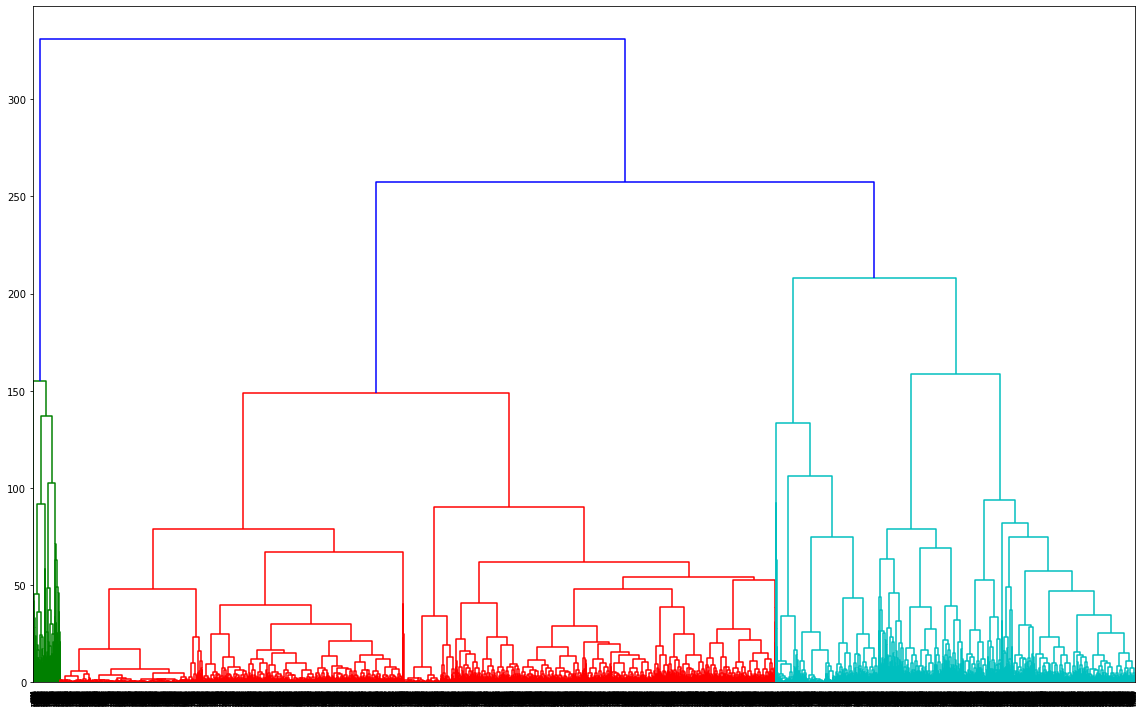

In [22]:
#Plotting the Dendogram
plt.figure(figsize=(16, 10));
plt.grid(False)
dend = scipy.cluster.hierarchy.dendrogram(aggl);

In [30]:
#Using k-modes we dervied k=5 for clustering
K=7
labels = scipy.cluster.hierarchy.fcluster(aggl, K, criterion="maxclust")

In [31]:
#Viewing each cluster and its statistics

from scipy import stats
import seaborn as sns

pd.set_option("display.precision", 2)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

print('All Data:')
print('Number of Instances: {}'.format(X.shape[0]))
df.describe(include=[np.number]).transpose()
df.describe(include=[np.object]).transpose()

for col in cat_col_names:
    df[col].value_counts()

for i, label in enumerate(set(labels)):
    n = df.iloc[labels==label].shape[0]
          
    print('\nCluster {}:'.format(label))
    print('Number of Instances: {}'.format(n))

    df.iloc[labels==label].describe(include=[np.number]).transpose()
    df.iloc[labels==label].describe(include=[np.object]).transpose()
    
    for col in cat_col_names:
        df.iloc[labels==label][col].value_counts()

All Data:
Number of Instances: 14427


,count,mean,std,min,25%,50%,75%,max
Twelve_Month_ADT,14427.00,459.22,391.33,23.89,253.86,331.89,511.20,3452.83
Six_Month_ADT,14427.00,397.21,421.17,0.00,189.87,298.90,471.61,6863.30
Three_Month_ADT,14427.00,346.43,443.68,0.00,51.19,257.44,437.85,10065.63
One_Month_ADT,14427.00,262.93,442.90,0.00,0.00,143.30,353.55,10065.63
Twelve_Month_Theo_NW,14427.00,14060.42,26156.53,225.03,1655.94,6724.34,15943.99,549540.29
Six_Month_Theo_NW,14427.00,7067.47,13935.00,0.00,603.01,3037.30,8074.35,306680.13
Three_Month_Theo_NW,14427.00,3582.07,7630.88,0.00,72.24,1405.36,4053.74,220288.86
One_Month_Theo_NW,14427.00,1202.13,2966.94,0.00,0.00,313.30,1369.02,92916.19
Twelve_Month_Actual_NW,14427.00,14177.63,30543.16,-246850.29,1454.40,6172.00,16122.84,773877.91
Six_Month_Actual_NW,14427.00,7044.65,17022.34,-321431.05,355.00,2896.65,8266.25,553502.91


,count,unique,top,freq
Mail_Consent,14427,2,Y,11001
Email_Consent,14427,2,N,8223
Tier,14427,3,GOLD,10345
City,14427,33,TORONTO,1802
Country,14427,4,Canada,14322
Age_Group,14427,8,59-66,3520
Gender,14427,2,FEMALE,7879
Lapse,14427,4,No Lapse,8559


Y    11001
N     3426
Name: Mail_Consent, dtype: int64

N    8223
Y    6204
Name: Email_Consent, dtype: int64

GOLD       10345
SILVER      3026
REWARDS     1056
Name: Tier, dtype: int64

TORONTO          1802
MISSISSAUGA      1757
Other_city       1724
NORTH YORK       1661
BRAMPTON         1362
ETOBICOKE        1182
SCARBOROUGH      1169
WOODBRIDGE        558
RICHMOND HILL     444
MARKHAM           413
THORNHILL         331
YORK              275
MAPLE             229
EAST YORK         191
OAKVILLE          160
PICKERING          96
AJAX               93
HAMILTON           93
BURLINGTON         93
BOLTON             88
MILTON             75
OSHAWA             74
NEWMARKET          72
WHITBY             60
LONDON             56
KITCHENER          54
AURORA             54
CONCORD            50
GUELPH             46
CALEDON            45
STOUFFVILLE        42
DOWNSVIEW          39
UNIONVILLE         39
Name: City, dtype: int64

Canada                      14322
United States of America       91
International Countries        13
England                         1
Name: Country, dtype: int64

59-66    3520
51-58    3448
67-74    2558
43-50    1976
75+      1357
35-42     979
27-34     471
19-26     118
Name: Age_Group, dtype: int64

FEMALE    7879
MALE      6548
Name: Gender, dtype: int64

No Lapse          8559
1 Month Lapsed    2533
6 Month Lasped    1766
3 Month Lapsed    1569
Name: Lapse, dtype: int64


Cluster 1:
Number of Instances: 5


,count,mean,std,min,25%,50%,75%,max
Twelve_Month_ADT,5.00,2624.38,473.81,2066.01,2324.11,2589.19,2852.99,3289.61
Six_Month_ADT,5.00,3603.86,1225.29,2270.71,2513.77,3562.57,4812.38,4859.86
Three_Month_ADT,5.00,4318.57,1830.38,2262.96,2794.55,4466.04,5348.57,6720.71
One_Month_ADT,5.00,4709.89,2332.06,2408.92,2590.04,4753.15,5807.26,7990.10
Twelve_Month_Theo_NW,5.00,351604.43,132065.77,199367.56,273037.74,319535.42,433861.15,532220.28
Six_Month_Theo_NW,5.00,208309.54,85361.45,120309.52,131216.11,199503.66,283838.29,306680.13
Three_Month_Theo_NW,5.00,133903.21,33624.81,96274.35,107531.32,129515.28,162932.92,173262.16
One_Month_Theo_NW,5.00,67684.38,14204.24,59570.86,60223.06,61790.99,63920.78,92916.19
Twelve_Month_Actual_NW,5.00,553144.93,226812.56,178007.89,549768.47,588068.38,676002.00,773877.91
Six_Month_Actual_NW,5.00,358651.13,154468.19,139624.89,288687.47,396337.38,415103.00,553502.91


,count,unique,top,freq
Mail_Consent,5,2,Y,3
Email_Consent,5,2,N,3
Tier,5,2,GOLD,4
City,5,4,RICHMOND HILL,2
Country,5,1,Canada,5
Age_Group,5,3,51-58,2
Gender,5,2,MALE,3
Lapse,5,1,No Lapse,5


Y    3
N    2
Name: Mail_Consent, dtype: int64

N    3
Y    2
Name: Email_Consent, dtype: int64

GOLD       4
SILVER     1
Name: Tier, dtype: int64

RICHMOND HILL    2
NORTH YORK       1
ETOBICOKE        1
TORONTO          1
Name: City, dtype: int64

Canada    5
Name: Country, dtype: int64

51-58    2
59-66    2
35-42    1
Name: Age_Group, dtype: int64

MALE      3
FEMALE    2
Name: Gender, dtype: int64

No Lapse    5
Name: Lapse, dtype: int64


Cluster 2:
Number of Instances: 343


,count,mean,std,min,25%,50%,75%,max
Twelve_Month_ADT,343.00,1174.79,794.87,99.51,523.97,1009.93,1619.83,3448.08
Six_Month_ADT,343.00,1235.37,871.45,86.54,543.87,1027.92,1723.02,4305.94
Three_Month_ADT,343.00,1233.97,919.07,0.00,520.92,1017.91,1639.65,5806.31
One_Month_ADT,343.00,1130.22,967.03,0.00,394.67,846.49,1623.42,6921.42
Twelve_Month_Theo_NW,343.00,118472.44,77884.32,16570.17,66031.76,102793.50,143820.05,549540.29
Six_Month_Theo_NW,343.00,64769.83,39502.70,10816.71,40237.07,56674.11,81911.80,267369.86
Three_Month_Theo_NW,343.00,33760.68,23496.96,0.00,19225.06,27671.20,40265.26,220288.86
One_Month_Theo_NW,343.00,10772.90,9991.30,0.00,4364.50,7751.78,13459.39,67419.74
Twelve_Month_Actual_NW,343.00,120232.37,100335.33,-246850.29,57178.40,102403.58,157209.54,596084.00
Six_Month_Actual_NW,343.00,62728.83,57201.32,-321431.05,27324.58,57099.50,90075.35,321062.00


,count,unique,top,freq
Mail_Consent,343,2,Y,245
Email_Consent,343,2,N,181
Tier,343,3,GOLD,288
City,343,29,Other_city,49
Country,343,3,Canada,336
Age_Group,343,8,51-58,94
Gender,343,2,FEMALE,177
Lapse,343,3,No Lapse,331


Y    245
N     98
Name: Mail_Consent, dtype: int64

N    181
Y    162
Name: Email_Consent, dtype: int64

GOLD       288
SILVER      51
REWARDS      4
Name: Tier, dtype: int64

Other_city       49
TORONTO          48
MISSISSAUGA      39
NORTH YORK       33
ETOBICOKE        25
SCARBOROUGH      24
BRAMPTON         24
WOODBRIDGE       16
THORNHILL        13
MARKHAM          13
RICHMOND HILL    12
MAPLE             7
OAKVILLE          6
BURLINGTON        4
AJAX              4
PICKERING         4
YORK              3
EAST YORK         3
AURORA            3
LONDON            2
CALEDON           2
WHITBY            2
HAMILTON          1
OSHAWA            1
MILTON            1
GUELPH            1
CONCORD           1
BOLTON            1
KITCHENER         1
Name: City, dtype: int64

Canada                      336
United States of America      5
International Countries       2
Name: Country, dtype: int64

51-58    94
59-66    88
67-74    48
43-50    45
35-42    31
75+      24
27-34    12
19-26     1
Name: Age_Group, dtype: int64

FEMALE    177
MALE      166
Name: Gender, dtype: int64

No Lapse          331
1 Month Lapsed     10
3 Month Lapsed      2
Name: Lapse, dtype: int64


Cluster 3:
Number of Instances: 4500


,count,mean,std,min,25%,50%,75%,max
Twelve_Month_ADT,4500.00,425.39,311.30,173.64,264.50,330.04,461.95,3349.60
Six_Month_ADT,4500.00,186.86,206.77,0.00,0.00,166.66,313.68,1752.16
Three_Month_ADT,4500.00,110.45,173.26,0.00,0.00,0.00,206.13,1201.04
One_Month_ADT,4500.00,27.52,89.63,0.00,0.00,0.00,0.00,974.64
Twelve_Month_Theo_NW,4500.00,3922.77,5175.28,225.19,762.70,2027.12,5251.68,68166.46
Six_Month_Theo_NW,4500.00,901.46,1410.90,0.00,0.00,297.16,1321.80,22283.08
Three_Month_Theo_NW,4500.00,273.45,533.20,0.00,0.00,0.00,349.80,9619.30
One_Month_Theo_NW,4500.00,41.07,157.11,0.00,0.00,0.00,0.00,4513.82
Twelve_Month_Actual_NW,4500.00,4156.09,6662.96,-112643.00,738.77,2310.80,5718.54,84149.45
Six_Month_Actual_NW,4500.00,1207.90,2256.78,-10785.00,0.00,222.11,1834.40,33041.00


,count,unique,top,freq
Mail_Consent,4500,2,Y,3406
Email_Consent,4500,2,N,2540
Tier,4500,3,GOLD,3080
City,4500,33,MISSISSAUGA,574
Country,4500,4,Canada,4465
Age_Group,4500,8,51-58,1115
Gender,4500,2,FEMALE,2522
Lapse,4500,4,6 Month Lasped,1764


Y    3406
N    1094
Name: Mail_Consent, dtype: int64

N    2540
Y    1960
Name: Email_Consent, dtype: int64

GOLD       3080
SILVER     1009
REWARDS     411
Name: Tier, dtype: int64

MISSISSAUGA      574
Other_city       574
TORONTO          533
NORTH YORK       492
SCARBOROUGH      397
BRAMPTON         392
ETOBICOKE        328
WOODBRIDGE       160
RICHMOND HILL    156
MARKHAM          126
THORNHILL        105
YORK              89
EAST YORK         64
MAPLE             61
OAKVILLE          54
PICKERING         33
BOLTON            32
OSHAWA            32
HAMILTON          32
AJAX              29
NEWMARKET         28
BURLINGTON        26
MILTON            26
AURORA            20
STOUFFVILLE       20
WHITBY            20
LONDON            20
KITCHENER         19
GUELPH            16
DOWNSVIEW         11
CONCORD           11
CALEDON           10
UNIONVILLE        10
Name: City, dtype: int64

Canada                      4465
United States of America      31
International Countries        3
England                        1
Name: Country, dtype: int64

51-58    1115
59-66    1077
67-74     796
43-50     604
75+       400
35-42     305
27-34     156
19-26      47
Name: Age_Group, dtype: int64

FEMALE    2522
MALE      1978
Name: Gender, dtype: int64

6 Month Lasped    1764
1 Month Lapsed    1226
3 Month Lapsed     835
No Lapse           675
Name: Lapse, dtype: int64


Cluster 4:
Number of Instances: 4880


,count,mean,std,min,25%,50%,75%,max
Twelve_Month_ADT,4880.00,403.92,232.36,62.65,256.69,328.45,467.35,1888.99
Six_Month_ADT,4880.00,417.21,249.82,0.00,262.18,341.25,483.47,1899.52
Three_Month_ADT,4880.00,339.72,274.51,0.00,189.19,300.36,447.65,2802.49
One_Month_ADT,4880.00,246.17,241.61,0.00,0.00,219.34,389.31,3894.03
Twelve_Month_Theo_NW,4880.00,9328.57,8431.11,225.54,2842.73,7598.64,13184.81,71971.45
Six_Month_Theo_NW,4880.00,4681.25,3865.45,0.00,1743.29,3817.71,6620.86,31043.00
Three_Month_Theo_NW,4880.00,2121.01,1935.94,0.00,622.37,1715.76,3086.14,13474.96
One_Month_Theo_NW,4880.00,678.32,815.72,0.00,0.00,428.42,1065.08,8193.31
Twelve_Month_Actual_NW,4880.00,9305.76,11054.65,-73479.50,2048.25,6901.57,13839.86,138753.00
Six_Month_Actual_NW,4880.00,4679.95,6087.80,-71020.39,1161.89,3724.94,7350.76,40225.35


,count,unique,top,freq
Mail_Consent,4880,2,Y,3783
Email_Consent,4880,2,N,2809
Tier,4880,3,GOLD,3409
City,4880,33,Other_city,601
Country,4880,3,Canada,4850
Age_Group,4880,8,59-66,1234
Gender,4880,2,FEMALE,2663
Lapse,4880,4,No Lapse,3417


Y    3783
N    1097
Name: Mail_Consent, dtype: int64

N    2809
Y    2071
Name: Email_Consent, dtype: int64

GOLD       3409
SILVER     1072
REWARDS     399
Name: Tier, dtype: int64

Other_city       601
TORONTO          587
MISSISSAUGA      580
NORTH YORK       550
BRAMPTON         498
SCARBOROUGH      427
ETOBICOKE        391
WOODBRIDGE       171
RICHMOND HILL    141
MARKHAM          130
YORK             101
THORNHILL        101
MAPLE             75
EAST YORK         68
OAKVILLE          56
BURLINGTON        34
AJAX              32
BOLTON            30
PICKERING         29
HAMILTON          28
OSHAWA            24
MILTON            24
NEWMARKET         23
CALEDON           22
LONDON            22
AURORA            21
UNIONVILLE        21
KITCHENER         19
WHITBY            18
CONCORD           17
GUELPH            16
STOUFFVILLE       12
DOWNSVIEW         11
Name: City, dtype: int64

Canada                      4850
United States of America      27
International Countries        3
Name: Country, dtype: int64

59-66    1234
51-58    1122
67-74     866
43-50     659
75+       466
35-42     337
27-34     155
19-26      41
Name: Age_Group, dtype: int64

FEMALE    2663
MALE      2217
Name: Gender, dtype: int64

No Lapse          3417
1 Month Lapsed     772
3 Month Lapsed     690
6 Month Lasped       1
Name: Lapse, dtype: int64


Cluster 5:
Number of Instances: 1339


,count,mean,std,min,25%,50%,75%,max
Twelve_Month_ADT,1339.00,368.54,242.47,36.09,239.66,296.63,415.26,1982.63
Six_Month_ADT,1339.00,379.45,244.98,43.52,243.35,307.23,434.06,1982.63
Three_Month_ADT,1339.00,388.67,247.54,0.00,247.90,315.43,446.67,1982.63
One_Month_ADT,1339.00,271.05,289.73,0.00,0.00,243.38,370.52,2500.92
Twelve_Month_Theo_NW,1339.00,2751.05,3172.59,225.03,510.90,1440.27,3895.33,24602.75
Six_Month_Theo_NW,1339.00,2451.39,2714.28,225.03,507.38,1388.65,3443.72,20351.88
Three_Month_Theo_NW,1339.00,2109.79,2252.64,0.00,494.92,1276.39,2979.92,19702.25
One_Month_Theo_NW,1339.00,1005.37,1381.63,0.00,0.00,587.17,1368.47,15837.16
Twelve_Month_Actual_NW,1339.00,2608.46,4436.59,-19027.20,354.19,1375.00,4160.67,27118.76
Six_Month_Actual_NW,1339.00,2234.94,4059.82,-19027.20,316.50,1257.18,3484.22,23142.72


,count,unique,top,freq
Mail_Consent,1339,2,Y,1031
Email_Consent,1339,2,N,759
Tier,1339,3,GOLD,958
City,1339,33,TORONTO,169
Country,1339,3,Canada,1328
Age_Group,1339,8,59-66,323
Gender,1339,2,FEMALE,738
Lapse,1339,3,No Lapse,970


Y    1031
N     308
Name: Mail_Consent, dtype: int64

N    759
Y    580
Name: Email_Consent, dtype: int64

GOLD       958
SILVER     287
REWARDS     94
Name: Tier, dtype: int64

TORONTO          169
NORTH YORK       165
MISSISSAUGA      154
Other_city       137
ETOBICOKE        124
BRAMPTON         121
SCARBOROUGH      106
WOODBRIDGE        53
MARKHAM           45
RICHMOND HILL     42
MAPLE             28
YORK              25
THORNHILL         24
EAST YORK         17
OAKVILLE          16
HAMILTON          15
AJAX              12
BURLINGTON        12
WHITBY             9
PICKERING          8
DOWNSVIEW          8
BOLTON             7
NEWMARKET          6
OSHAWA             5
AURORA             5
KITCHENER          5
MILTON             4
GUELPH             4
LONDON             4
CALEDON            3
CONCORD            3
STOUFFVILLE        2
UNIONVILLE         1
Name: City, dtype: int64

Canada                      1328
United States of America      10
International Countries        1
Name: Country, dtype: int64

59-66    323
51-58    320
67-74    237
43-50    174
75+      147
35-42     90
27-34     39
19-26      9
Name: Age_Group, dtype: int64

FEMALE    738
MALE      601
Name: Gender, dtype: int64

No Lapse          970
1 Month Lapsed    368
3 Month Lapsed      1
Name: Lapse, dtype: int64


Cluster 6:
Number of Instances: 1112


,count,mean,std,min,25%,50%,75%,max
Twelve_Month_ADT,1112.00,1048.17,631.11,135.03,617.33,825.01,1279.83,3452.83
Six_Month_ADT,1112.00,1108.46,695.81,129.88,646.47,880.57,1342.89,6863.30
Three_Month_ADT,1112.00,1084.83,755.83,0.00,645.94,897.85,1293.04,10065.63
One_Month_ADT,1112.00,958.40,841.72,0.00,492.24,840.43,1207.10,10065.63
Twelve_Month_Theo_NW,1112.00,36952.27,27793.79,1210.68,15963.36,31791.06,50131.23,182823.72
Six_Month_Theo_NW,1112.00,19142.91,13853.52,389.63,9271.23,17002.14,25969.72,141228.85
Three_Month_Theo_NW,1112.00,10177.50,7402.60,0.00,4449.38,8849.27,14326.08,66904.20
One_Month_Theo_NW,1112.00,3431.46,3348.74,0.00,1050.33,2562.70,4978.24,33475.23
Twelve_Month_Actual_NW,1112.00,36240.39,33632.31,-142544.85,13568.72,29863.32,53303.18,226385.17
Six_Month_Actual_NW,1112.00,18078.89,18217.54,-150440.85,6947.61,15737.79,27165.96,136976.00


,count,unique,top,freq
Mail_Consent,1112,2,Y,778
Email_Consent,1112,2,N,603
Tier,1112,3,GOLD,914
City,1112,33,Other_city,172
Country,1112,3,Canada,1099
Age_Group,1112,8,51-58,281
Gender,1112,2,FEMALE,564
Lapse,1112,3,No Lapse,982


Y    778
N    334
Name: Mail_Consent, dtype: int64

N    603
Y    509
Name: Email_Consent, dtype: int64

GOLD       914
SILVER     163
REWARDS     35
Name: Tier, dtype: int64

Other_city       172
TORONTO          135
MISSISSAUGA      123
NORTH YORK       122
BRAMPTON          97
SCARBOROUGH       76
ETOBICOKE         68
WOODBRIDGE        52
THORNHILL         47
MARKHAM           42
RICHMOND HILL     36
MAPLE             20
YORK              18
OAKVILLE          16
PICKERING         11
EAST YORK          9
MILTON             7
NEWMARKET          6
BOLTON             6
HAMILTON           6
BURLINGTON         5
STOUFFVILLE        5
OSHAWA             4
UNIONVILLE         4
WHITBY             4
CONCORD            4
GUELPH             3
AURORA             3
LONDON             3
CALEDON            3
KITCHENER          2
AJAX               2
DOWNSVIEW          1
Name: City, dtype: int64

Canada                      1099
United States of America      10
International Countries        3
Name: Country, dtype: int64

51-58    281
59-66    259
43-50    203
67-74    171
35-42     80
75+       70
27-34     45
19-26      3
Name: Age_Group, dtype: int64

FEMALE    564
MALE      548
Name: Gender, dtype: int64

No Lapse          982
1 Month Lapsed     99
3 Month Lapsed     31
Name: Lapse, dtype: int64


Cluster 7:
Number of Instances: 2248


,count,mean,std,min,25%,50%,75%,max
Twelve_Month_ADT,2248.00,295.68,206.25,23.89,159.01,247.85,367.86,2065.38
Six_Month_ADT,2248.00,298.62,210.84,0.00,163.11,245.18,374.12,2000.42
Three_Month_ADT,2248.00,298.69,215.50,0.00,161.78,242.13,373.79,2307.35
One_Month_ADT,2248.00,279.47,232.62,0.00,144.51,227.26,351.42,5476.40
Twelve_Month_Theo_NW,2248.00,23356.38,15749.95,2717.10,13463.31,19448.98,28761.32,243715.41
Six_Month_Theo_NW,2248.00,12114.94,7954.60,0.00,6890.04,10304.52,15086.10,100233.07
Three_Month_Theo_NW,2248.00,6096.82,4056.66,0.00,3469.93,5038.04,7696.23,38435.95
One_Month_Theo_NW,2248.00,2069.69,1561.16,0.00,1141.92,1666.04,2625.43,15336.88
Twelve_Month_Actual_NW,2248.00,23411.34,20450.50,-45442.00,11695.01,18962.46,30553.39,200568.00
Six_Month_Actual_NW,2248.00,11990.15,11311.10,-38788.12,5607.44,9834.99,15998.86,164902.75


,count,unique,top,freq
Mail_Consent,2248,2,Y,1755
Email_Consent,2248,2,N,1328
Tier,2248,3,GOLD,1692
City,2248,33,TORONTO,329
Country,2248,3,Canada,2239
Age_Group,2248,8,59-66,537
Gender,2248,2,FEMALE,1213
Lapse,2248,4,No Lapse,2179


Y    1755
N     493
Name: Mail_Consent, dtype: int64

N    1328
Y     920
Name: Email_Consent, dtype: int64

GOLD       1692
SILVER      443
REWARDS     113
Name: Tier, dtype: int64

TORONTO          329
NORTH YORK       298
MISSISSAUGA      287
ETOBICOKE        245
BRAMPTON         230
Other_city       191
SCARBOROUGH      139
WOODBRIDGE       106
MARKHAM           57
RICHMOND HILL     55
THORNHILL         41
YORK              39
MAPLE             38
EAST YORK         30
CONCORD           14
AJAX              14
MILTON            13
BOLTON            12
OAKVILLE          12
BURLINGTON        12
PICKERING         11
HAMILTON          11
NEWMARKET          9
KITCHENER          8
OSHAWA             8
DOWNSVIEW          8
WHITBY             7
GUELPH             6
CALEDON            5
LONDON             5
UNIONVILLE         3
STOUFFVILLE        3
AURORA             2
Name: City, dtype: int64

Canada                      2239
United States of America       8
International Countries        1
Name: Country, dtype: int64

59-66    537
51-58    514
67-74    440
43-50    291
75+      250
35-42    135
27-34     64
19-26     17
Name: Age_Group, dtype: int64

FEMALE    1213
MALE      1035
Name: Gender, dtype: int64

No Lapse          2179
1 Month Lapsed      58
3 Month Lapsed      10
6 Month Lasped       1
Name: Lapse, dtype: int64

In [27]:
#for i, label in enumerate(set(labels)):
n = df.iloc[labels==1].shape[0]
c1=df.iloc[labels==1].describe(include=[np.number]).transpose()
c1.to_csv('cluster1.csv')

n = df.iloc[labels==2].shape[0]
c1=df.iloc[labels==2].describe(include=[np.number]).transpose()
c1.to_csv('cluster2.csv')

n = df.iloc[labels==3].shape[0]
c1=df.iloc[labels==3].describe(include=[np.number]).transpose()
c1.to_csv('cluster3.csv')

n = df.iloc[labels==4].shape[0]
c1=df.iloc[labels==4].describe(include=[np.number]).transpose()
c1.to_csv('cluster4.csv')

n = df.iloc[labels==5].shape[0]
c1=df.iloc[labels==5].describe(include=[np.number]).transpose()
c1.to_csv('cluster5.csv')


n = df.iloc[labels==6].shape[0]
c1=df.iloc[labels==6].describe(include=[np.number]).transpose()
c1.to_csv('cluster6.csv')


n = df.iloc[labels==7].shape[0]
c1=df.iloc[labels==7].describe(include=[np.number]).transpose()
c1.to_csv('cluster7.csv')

In [33]:
import dill
dill.dump_session('MMA831.db')